# Aim  2 Analysis: Characterizing The Effect of CD7 in Restricting HSC Potential 

In this notebook, we will be completing our analysis of Days 7 - Day 13 of the CD34+ Cells in LEM. 

The Research Questions of this Aim are: 
1. Is There a Difference in CD7 expression between Days 7, 10 and 13, across all HSCs or within each Population?

2. Is There a Statistical Difference in CD7 Expression Between Ra-C- cells (Primitive), and Ra-C+/C+ Populations (Morer Mature)? 

3. Does the Increase in CD7 Expression statisticallly correlate with an Increase in Known T-Cell Gene Expression?  

4. Do Clusters of CD7 Enriched Population Also Have High T-Cell Gene Enrichment? (Across all pools, and within each population)

5. Do CD7+ Cells Have Better T-Cell Gene Enrichment Compared to RA+ Cells (i.e., is RA-positivity a more important marker for T-lineage commitment)? 

6. Is There are Correlations Between CD7 and Other CD Markers Temporally, or Ra-C- (Primitive) to RA+C-/C+ populations (Mature)? 

7. What are the Top Transcriptional Drivers/Regulators in CD7+ Cells? 

## Pre-Processing and Data Preparation


Let's begin by loading any of our necessary libraries, and loading our CITE-Seq data into this notebook: 

In [1]:
# Loading Libraries

library(BiocSingular) # We need this to use the BioConductor libraries that work on the Single Cell data. #nolint
library(SingleCellExperiment) # We need this to use the SingleCellExperiment data structure.  # nolint
library(ggplot2) # we need this to make ggplot visualizations #nolint
library(tidyr) # we need this to manipulate data #nolint
library(dplyr) # we need this to manipulate data #nolint
library(patchwork) # to display plots side by side. #nolint
library(ggforce) # Allows me to display circles on ggplots. #nolint
library(limma) # helps with differential expression analysis #nolint
library(IRdisplay) # lets me display JPEGs in the notebook #nolint
library(org.Hs.eg.db) # lets me do gene annotation #nolint
library(clusterProfiler) # lets me do gene set enrichment analysis #nolint
library(tidyverse) # lets me manipulate data #nolint
library(broom) # lets me manipulate data #nolint


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges

Once again, refer to `d0_analysis.ipynb` to look at the process by which I have created my sce object. For now, I am going to load it in, instead of repeating the process to save time. Then, I will be adding phenotype data and population markers to this sce object as columns (as down in `Aim1_Analysis.ipynb`). 

In [2]:
load("data/phenotype_with_ID.RData")
load("data/merge2.RData")

# Adding Phenotype data to the SCE object
pheno.d7 <- rep("CD34+CD45RA-CLEC12A-", 3039)
names(pheno.d7) <- colnames(merge2)[1:3039]

pheno.merge2 <- c(pheno.d7, pheno.d10, pheno.d13)


colData(merge2)$Phenotype <- pheno.merge2


# Cleaning Up the Phenotype Data so it belongs to the 3 populations

# Define phenotype groups
phenotype_groups <- list(
    Raneg_Cneg = c("CD34+CD45RA-CLEC12A-", "CD34-CD45RA-CLEC12A-"), # Ra-C-
    Rapos_Cneg = c("CD34+CD45RA+CLEC12A-", "CD34-CD45RA+CLEC12A-"), # Ra+C-
    Cpos = c("CD34-CD45RA-CLEC12A+", "CD34+CD45RA-CLEC12A+", "CD34+CD45RA+CLEC12A+", "CD34-CD45RA+CLEC12A+"), # C+ # nolint
    Other = c("CD10+", "CD14CD15+") # Pro -B #Pro-NM #FW Gating from a flow cytometer #nolint
)

# Assign group labels to phenotypes
group_labels <- sapply(pheno.merge2, function(phenotype) {
    group <- names(phenotype_groups)[sapply(phenotype_groups, function(g) phenotype %in% g)] # nolint
    if (length(group) > 0) group else "Other"
})

# Add group labels to colData of the SCE object
colData(merge2)$Group <- group_labels


Next, lets add a column indicating which day each observation belongs too, as we will be doing time sensitive analysis in the coming sections as well: 

In [3]:
# Extract the day information from cell names
colData(merge2)$Day <- gsub(".*Day_([0-9]+).*", "\\1", rownames(colData(merge2)))
# Convert to a factor (optional, for better categorical handling)
colData(merge2)$Day <- factor(colData(merge2)$Day, levels = sort(unique(colData(merge2)$Day)))


# Define columns to keep
cols_to_keep <- c("Group", "Day", "Phenotype")

# Create a lighter version of the SCE object
merge2_light <- merge2
colData(merge2_light) <- colData(merge2_light)[, cols_to_keep]

# Checking characteristics of the new light version
merge2_light
colnames(colData(merge2_light))


class: SingleCellExperiment 
dim: 36601 12181 
metadata(12): Samples scDblFinder.stats ... scDblFinder.stats
  scDblFinder.threshold
assays(2): counts logcounts
rownames(36601): MIR1302-2HG FAM138A ... AC007325.4 AC007325.2
rowData names(3): ID Symbol Type
colnames(12181): cell1Day_7 cell2Day_7 ... cell5137Day_13
  cell5138Day_13
colData names(3): Group Day Phenotype
reducedDimNames(9): PCA.cc UMAP.cc ... PCA TSNE
mainExpName: Gene Expression
altExpNames(1): Antibody Capture

[1] "Group"     "Day"       "Phenotype"

Nice! As a Sanity Check, let's explore the makeup of the 3 populations, and their timepoints, using a simple tibble: 

In [4]:
table(colData(merge2_light)$Group, colData(merge2)$Day)


            
               10   13    7
  Cpos       1407 2219    0
  Other       264 1023    0
  Raneg_Cneg 1815  608 3039
  Rapos_Cneg  766 1040    0

* Day 7 data exists only for Raneg_Cneg (i.e., primitive/early cells). Makes sense as only Ra-C- were sorted on Day 7, making it the input population. 

* Day 10 and Day 13 have more mature populations like Cpos and Rapos_Cneg.

This makes sense developmentally and supports the  idea that CD7 expression might increase over time as cells mature.

Finally, since CD7 **does**  exist inthe ADT Assay of the Cite-Seq data (that is, Fangwu tagged the antibody with a fluorochrome during experimental setup), we will be able to use the Flow Cytometry results to to gate CD7+ and CD7- populations. 

We will do this in conjunction with CD7 gene RNA Distribution and, annotate CD7hi population and CD7lo populations. 

In [5]:
# Check available assays in the Antibody Capture altExp
assayNames(altExp(merge2, "Antibody Capture"))

# Check if "CD7" is among the rownames
"CD7" %in% rownames(altExp(merge2, "Antibody Capture"))

# Or view all available markers:
rownames(altExp(merge2, "Antibody Capture"))


[1] "counts"    "logcounts"

[1] FALSE

[1] "TOTALSEQB_CLEC12A" "TOTALSEQB_CD45RA"  "TOTALSEQB_CD10"   
[4] "TOTALSEQB_CD7"     "TOTALSEQB_CD34"    "TOTALSEQB_CD14"   
[7] "TOTALSEQB_CD15"

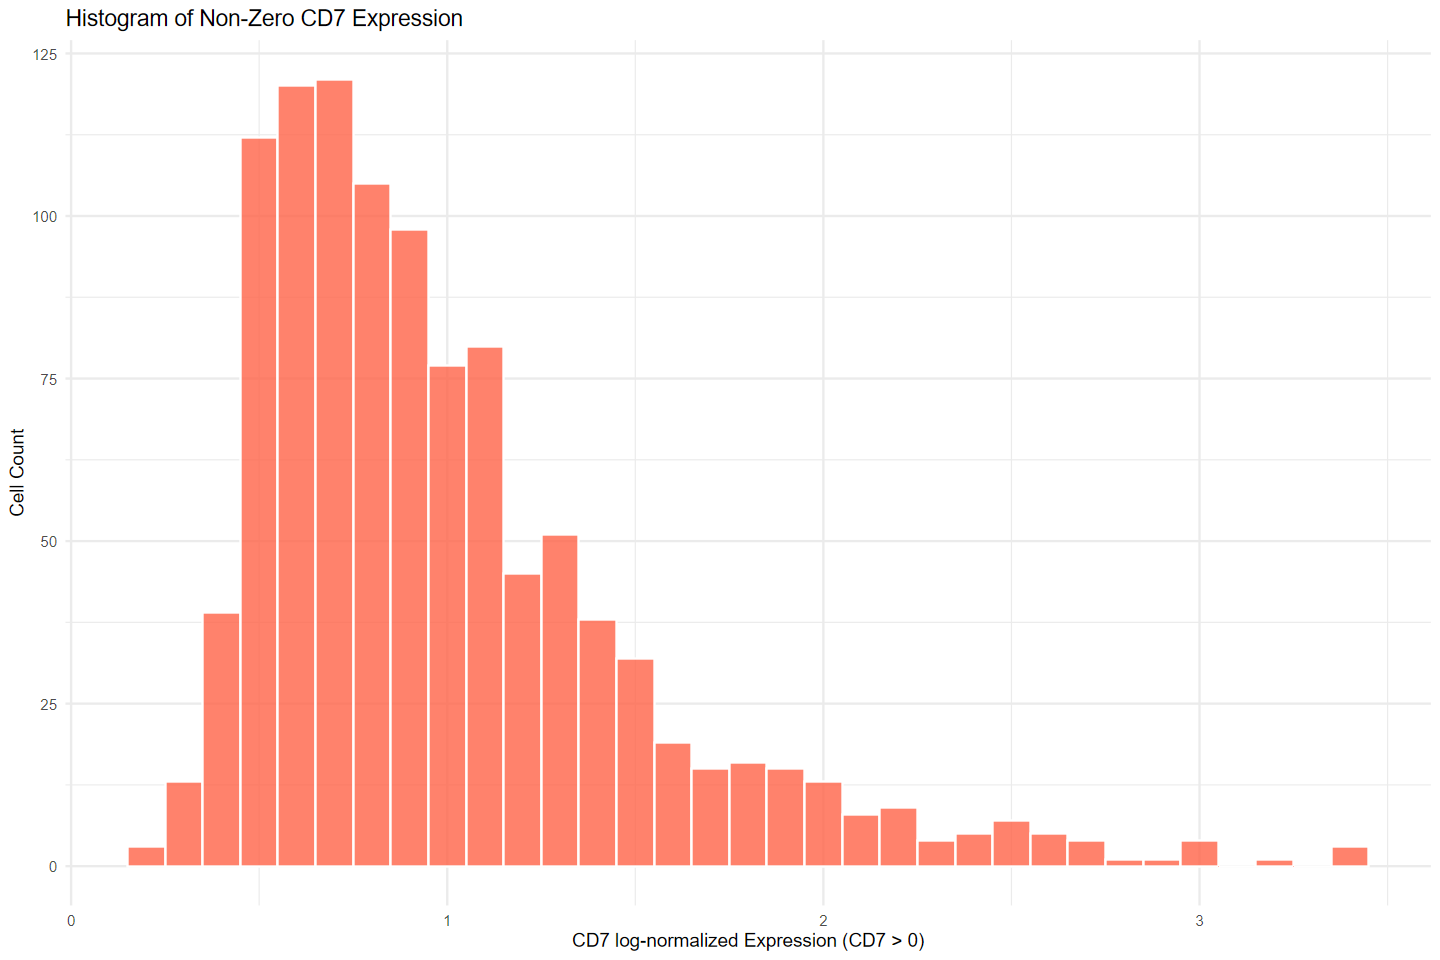

In [6]:
# Creating a Violin Plot to Generate CD7 Distribution Across All Cells Overall

options(repr.plot.width = 12, repr.plot.height = 8)

# 1. Extract CD7 expression from the RNA assay
cd7_expr <- logcounts(merge2_light)["CD7", ]


# 2. Add CD7 expression to metadata
colData(merge2_light)$CD7_gene <- cd7_expr

# Filter to cells with CD7_expr > 0
# becuase otherwise the plot becomes right skewed and useless
nonzero_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_gene > 0)

# Plot histogram of non-zero CD7 expression
ggplot(nonzero_df, aes(x = CD7_gene)) +
  geom_histogram(binwidth = 0.1, fill = "tomato", color = "white", alpha = 0.8) +
  labs(
    title = "Histogram of Non-Zero CD7 Expression",
    x = "CD7 log-normalized Expression (CD7 > 0)",
    y = "Cell Count"
  ) +
  theme_minimal()


Nice! We can see the clean distribution using this histogram! Here's my interpretation of it: 

* There's a dense peak between ~0.5 to ~1.5, with a long right-skewed tail extending up to ~3.2.
* This suggests a natural break point between low-but-detectable CD7 expression and robust CD7⁺ expression.

So this is the gating structure I will be implementing, based on this: 
CD7 Status | Expression Range (CD7_expr)	| Rationale|
-----------|--------------------------------|----------|
CD7_0	|≤ 0	|Truly negative|
CD7-lo	|> 0 & < 1	|Weak expression; transitional or noise|
CD7-hi	|≥ 1	|Stronger, confident expression|

Let implement it in the code chunk below: 

In [7]:
colData(merge2_light)$CD7_geneStat <- case_when(
  merge2_light$CD7_gene == 0 ~ "CD7_0",
  merge2_light$CD7_gene >= 1 ~ "CD7_hi",
  TRUE ~ "CD7_lo" # Optional middle category
)


Great - now lets do the same with the ADT flow cytometry data as well: 

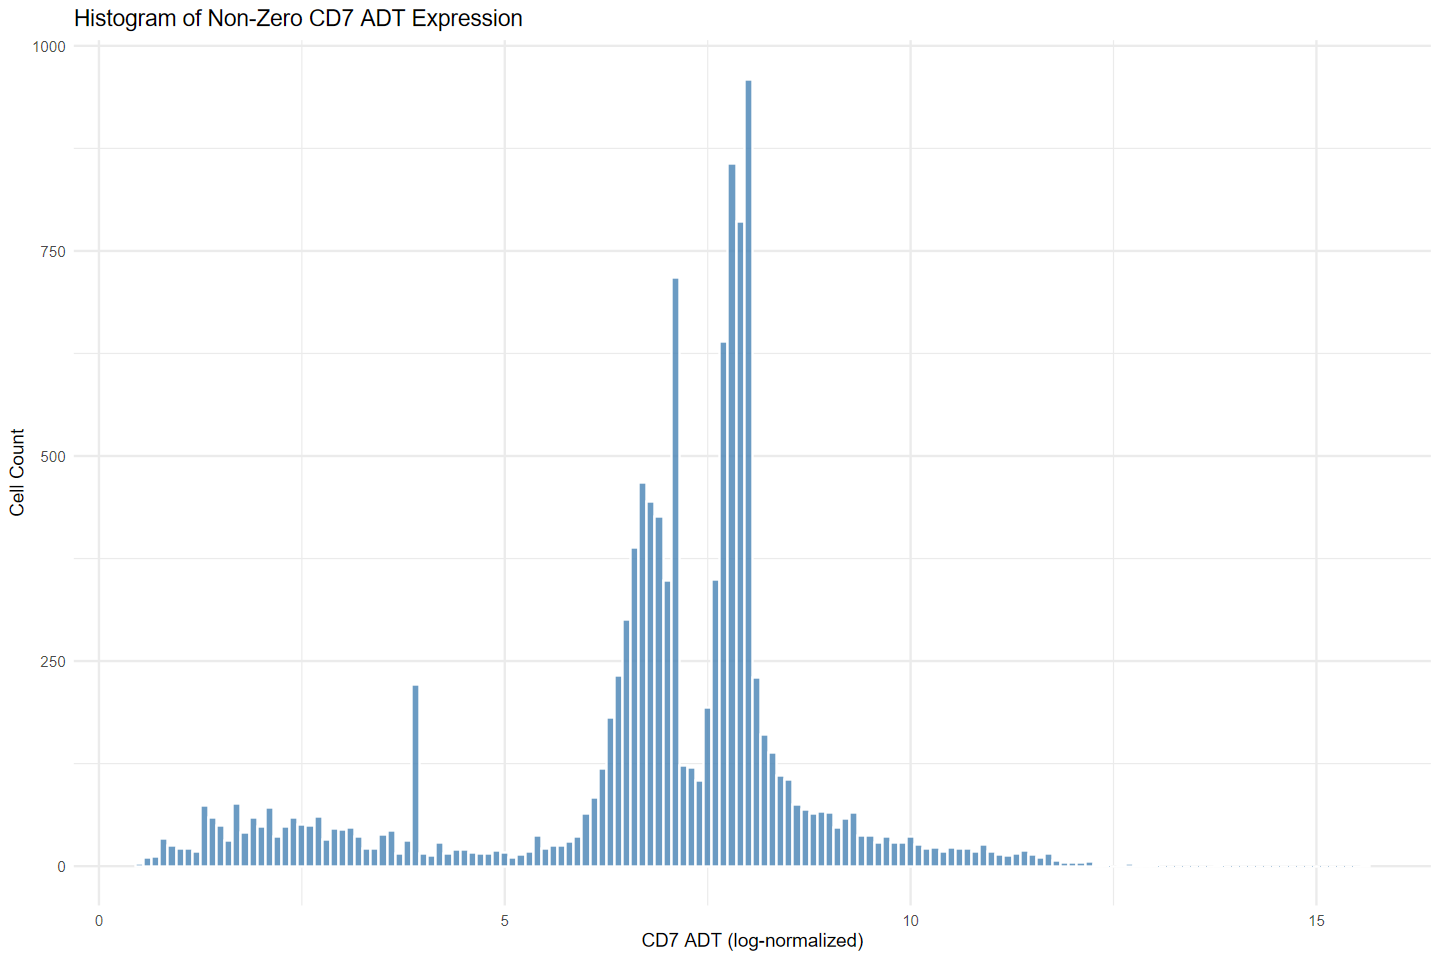

In [8]:
# Extract CD7 ADT signal from Antibody Capture assay
cd7_adt <- logcounts(altExp(merge2_light, "Antibody Capture"))["TOTALSEQB_CD7", ]
colData(merge2_light)$CD7_adt <- cd7_adt

# Filter to non-zero ADT values to avoid heavy skew
adt_nonzero <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_adt > 0)

# Plot histogram
ggplot(adt_nonzero, aes(x = CD7_adt)) +
  geom_histogram(binwidth = 0.1, fill = "steelblue", color = "white", alpha = 0.8) +
  labs(
    title = "Histogram of Non-Zero CD7 ADT Expression",
    x = "CD7 ADT (log-normalized)",
    y = "Cell Count"
  ) +
  theme_minimal()


Interesting, looking at this plot, here's what I see: 
* Left peak: Around ~2.5–4.5 → likely CD7⁻ or low-expressing population.

* Right peak: Sharp and dominant around ~7.5–9 → clearly CD7⁺ cells.

* There's a clear valley between ~5.5 and 6.5, which is ideal for a gating threshold.

The **bimodal distribution** is super clear here. Based on what I see, here's the gating strategy I propose:

**Gating Strategy for CD7 ADT**:

| Gate        | Range (CD7_adt) | Rationale                           |
|-------------|------------------|-------------------------------------|
| **CD7-**   | `≤ 1`            | Undetectable expression (log-space 0) |
| **CD7~**  | `> 1 & < 6`      | Ambiguous or transitional zone     |
| **CD7+**  | `≥ 6`            | Robust protein-level CD7 expression |

In [9]:
colData(merge2_light)$CD7_adtStat <- case_when(
  merge2_light$CD7_adt <= 1 ~ "CD7-",
  merge2_light$CD7_adt >= 6 ~ "CD7+",
  TRUE ~ "CD7~"
)

colnames(colData(merge2_light))


[1] "Group"        "Day"          "Phenotype"    "CD7_gene"     "CD7_geneStat"
[6] "CD7_adt"      "CD7_adtStat"

Finally, as a sanity check, I want to compare the levels of Protein expression and RNA expression across the entire population, to see if it correlates generally: 

`geom_smooth()` using formula = 'y ~ x'



	Pearson's product-moment correlation

data:  corr_df$CD7_gene and corr_df$CD7_adt
t = 13.127, df = 963, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3347217 0.4418440
sample estimates:
      cor 
0.3895997 


Warning message in cor.test.default(corr_df$CD7_gene, corr_df$CD7_adt, method = "spearman"):
"Cannot compute exact p-value with ties"



	Spearman's rank correlation rho

data:  corr_df$CD7_gene and corr_df$CD7_adt
S = 98623959, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.3415054 


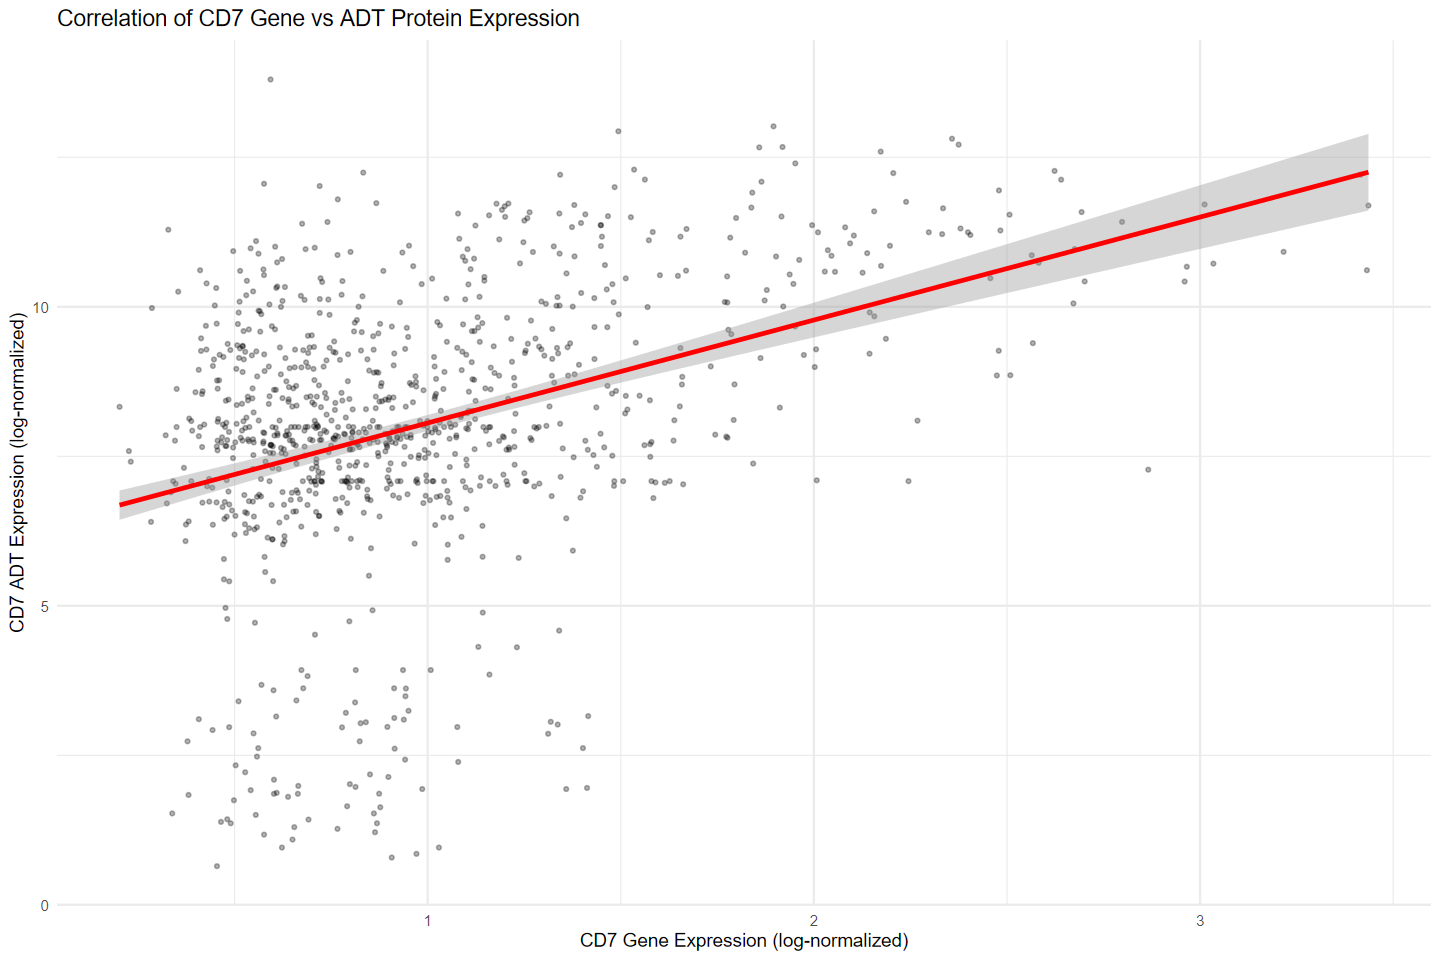

In [10]:
# Extract both columns from colData
corr_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_gene > 0, CD7_adt > 0, Group != "Other") # optional: restrict to nonzero expression & exclude 'Other'


library(ggplot2)

ggplot(corr_df, aes(x = CD7_gene, y = CD7_adt)) +
  geom_point(alpha = 0.3, size = 0.7) +
  geom_smooth(method = "lm", se = TRUE, color = "red") +
  labs(
    title = "Correlation of CD7 Gene vs ADT Protein Expression",
    x = "CD7 Gene Expression (log-normalized)",
    y = "CD7 ADT Expression (log-normalized)"
  ) +
  theme_minimal()

# Pearson correlation (linear relationship)
cor.test(corr_df$CD7_gene, corr_df$CD7_adt, method = "pearson")

# Optionally: Spearman correlation (rank-based)
cor.test(corr_df$CD7_gene, corr_df$CD7_adt, method = "spearman")


In [11]:
table(CD7_gene = merge2_light$CD7_gene > 0, CD7_adt = merge2_light$CD7_adt > 0)


        CD7_adt
CD7_gene FALSE  TRUE
   FALSE   432 10685
   TRUE     24  1040

Oh Dear! This is quiet scary. It appears that there are 10,685 cells that are producing the CD7 ADT protein, but have CD7 gene expression. Look's like this is a case of non-specific binding (or as Ross called, it, CITE-Seq being "Sticky"). 

We will fix this by re-labelling cells with Zero CD7 expression as being "CD7-", regardless of protein level.

In [12]:
# Identify which cells have CD7_gene == 0
zero_gene_idx <- which(colData(merge2_light)$CD7_gene == 0)

# Set their ADT expression to 0
colData(merge2_light)$CD7_adt[zero_gene_idx] <- 0

# Set their ADT status to "CD7-"
colData(merge2_light)$CD7_adtStat[zero_gene_idx] <- "CD7-"

# Check the updated data frame
table(CD7_gene = merge2_light$CD7_gene > 0, CD7_adt = merge2_light$CD7_adt > 0)


        CD7_adt
CD7_gene FALSE  TRUE
   FALSE 11117     0
   TRUE     24  1040

Great! We are now ready to begin working on the first Research Question of this analysis. 

## Analysis Workflow 

### RQ1: Is There a Difference in CD7 expression between Days 7, 10 and 13, across all HSCs or within each Population?

CD7 may be a marker that increases as cells progress towards a T-lineage. Understanding its temporal dynamics across differentiation days should be the first sanity check we conduct to see if it is actually doing anything. The overall population of cells are maturing over time in LEM culture (which is designed to support Lymphoid specificiation). CD7 is a surface marker that is belived to be enriched in early T-lineage committed cells. 

Given that the progression of populations from Day 7 to Day 13 involves a lot of maturation and lineage specification, one would expect to see higher levels of CD7 as time progresses across the overall CD34+ HSC population as a whole, and within each of the individual population subsets. 

This is what we will explore and interpret in this section. We will do so in 2 phases: 

* **Phase 1 - Qualitative CD7 RNA and ADT Trends over Time**: We will plot CD7 RNA Expression across Days 7, 10 and 13, (across all HSCs, and within each population group), and then visualize the proportion of CD7+ positivity as time progresses, helping see qualitatively if CD7 increases with time.. 

* **Phase 2- Statistical Testing of CD7 Trends Over Time**:  We will conduct statistical testing to discern differences between CD7 expression level (ADT or GeneExpression) and their populations. 

Lets begin with implementing phase 1

#### Phase 1: Qualitative Visualization and Interpretation of General Trends 

Let's begin by generating our first faceted plot,containing CD7 expression Vs. Day (All HSCs, filtering CD7+/Low only), and the same information  faceted by population (3 Pops, filtering CD7+/Low only):   

In [13]:
# Implementing the BoxPlot Visualizations for CD7 Expression Across All Popuulations #nolint

options(repr.plot.width = 18, repr.plot.height = 9)

# Filter out CD7- cells
cd7_filtered_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_geneStat != "CD7_0") %>%
  filter(Group != "Other")

# Reorder Day as a factor with levels in desired order
cd7_filtered_df$Day <- factor(cd7_filtered_df$Day, levels = c("7", "10", "13"))

# Plot 1: Overall Boxplot (All groups combined)
CD7_gene_expression_plot_HSC <- ggplot(cd7_filtered_df, aes(x = Day, y = CD7_gene)) + # nolint
  geom_boxplot(fill = "steelblue", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, alpha = 0.2, size = 0.5) +
  labs(
    subtitle = "For All HSCs",
    x = "Day",
    y = "CD7 Log-Normalized Gene Expression"
  ) +
  theme_minimal()

# Plot 2: Faceted by Population Group
CD7_gene_expression_plot_GROUP <- ggplot(cd7_filtered_df, aes(x = Day, y = CD7_gene)) + # nolint
  geom_boxplot(fill = "darkorange", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, alpha = 0.2, size = 0.5) +
  facet_wrap(~Group) +
  labs(
    subtitle = "By Population",
    x = "Day",
    y = ""
  ) +
  theme_minimal()

CombPlot_CD7_gene_expression <- CD7_gene_expression_plot_HSC + CD7_gene_expression_plot_GROUP + plot_layout(ncol = 2) + # nolint
  plot_annotation(title = "CD7 Gene Expression Across Time by HSC Population & Group") & # nolint
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.subtitle = element_text(size = 15, face = "italic"),
    strip.text = element_text(size = 12)
  )


Great! Now, let's do the same with our ADT data: 

In [14]:
options(repr.plot.width = 18, repr.plot.height = 9)

# Filter out CD7- (ADT = 0) cells for meaningful distribution
adt_filtered_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_adt > 0 & Group != "Other")

# Ensure Day is treated as an ordered factor
adt_filtered_df$Day <- factor(adt_filtered_df$Day, levels = c("7", "10", "13"))

# Plot 1: CD7 ADT expression over time (All HSCs)
CD7_adt_count_plot_HSC <- ggplot(adt_filtered_df, aes(x = Day, y = CD7_adt)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, alpha = 0.1, size = 0.5) +
  labs(
    subtitle = "All HSCs",
    x = "Day",
    y = "CD7 ADT log-normalized Expression"
  ) +
  theme_minimal()

# Plot 2: Faceted by Group
CD7_adt_count_plot_GROUP <- ggplot(adt_filtered_df, aes(x = Day, y = CD7_adt)) +
  geom_boxplot(fill = "darkorange", alpha = 0.7, outlier.shape = NA) +
  geom_jitter(width = 0.2, alpha = 0.1, size = 0.5) +
  facet_wrap(~Group) +
  labs(
    subtitle = "By Population",
    x = "Day",
    y = ""
  ) +
  theme_minimal()


CombPlot_CD7_adt_expression <- CD7_adt_count_plot_HSC + CD7_adt_count_plot_GROUP + plot_layout(ncol = 2) + # nolint
  plot_annotation(title = "Proportion of CD7 ADT Log Fluorescence Across Time by HSC Population & Group") & # nolint
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.subtitle = element_text(size = 15, face = "italic"),
    strip.text = element_text(size = 12)
  )


Amazing! Now, let's generate the Proportion plots based on the GeneExpression data: 

In [15]:
options(repr.plot.width = 18, repr.plot.height = 9)

# Ensure Day is a factor in the right order
cd7_filtered_df$Day <- factor(cd7_filtered_df$Day, levels = c("7", "10", "13"))

# Create the normalized stacked bar plot
CD7_gene_prop_plot_HSC <- ggplot(cd7_filtered_df, aes(x = Day, fill = CD7_geneStat)) + # nolint
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    subtitle = "All HSCs",
    x = "Day",
    y = "Proportion of Cells",
    fill = "CD7 Status"
  ) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"), # nolint
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.subtitle = element_text(size = 15, face = "italic"),
    strip.text = element_text(size = 12)
  ) +
  theme_minimal()

CD7_gene_prop_plot_GROUP <- ggplot(cd7_filtered_df, aes(x = Day, fill = CD7_geneStat)) + # nolint
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    subtitle = "By Population",
    x = "Day",
    y = "",
    fill = "CD7 Gene Status"
  ) +
  facet_wrap(~Group) +
  theme_minimal()

CombPlot_CD7_gene_prop <- CD7_gene_prop_plot_HSC + CD7_gene_prop_plot_GROUP + plot_layout(ncol = 2) + # nolint
  plot_annotation(title = "Proportion of CD7 Gene Expression Across Time by HSC Population & Group") & # nolint
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.subtitle = element_text(size = 15, face = "italic"),
    strip.text = element_text(size = 12)
  )


Great! Now, we repeat with the ADT data: 

In [16]:
# Ensure Day is a factor in the right order
adt_filtered_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_adtStat != "CD7-" & Group != "Other")

# Ensure Day is treated as an ordered factor
adt_filtered_df$Day <- factor(adt_filtered_df$Day, levels = c("7", "10", "13"))


# ---- Plot 1: Overall Proportion Across All HSCs ----
CD7_adt_prop_plot_HSC <- ggplot(adt_filtered_df, aes(x = Day, fill = CD7_adtStat)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    subtitle = "All HSCs",
    x = "Day",
    y = "Proportion of Cells",
    fill = "CD7 ADT Status"
  ) +
  theme_minimal()

# ---- Plot 2: Faceted by Population Group ----
CD7_adt_prop_plot_GROUP <- ggplot(adt_filtered_df, aes(x = Day, fill = CD7_adtStat)) +
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent_format()) +
  labs(
    subtitle = "By Population",
    x = "Day",
    y = "",
    fill = "CD7 ADT Status"
  ) +
  facet_wrap(~Group) +
  theme_minimal()

# ---- Combine the two plots ----
CombPlot_CD7_adt_prop <- CD7_adt_prop_plot_HSC + CD7_adt_prop_plot_GROUP +
  plot_layout(ncol = 2) +
  plot_annotation(
    title = "Proportion of CD7 ADT Expression Across Time by HSC Population & Group",
    theme = theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))
  ) & # nolint
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
    axis.title = element_text(size = 14),
    axis.text = element_text(size = 12),
    plot.subtitle = element_text(size = 15, face = "italic"),
    strip.text = element_text(size = 12)
  )


Woohoo! That was a lot of code. Let's now combine all the plots into one figure, and interpret what we see: 

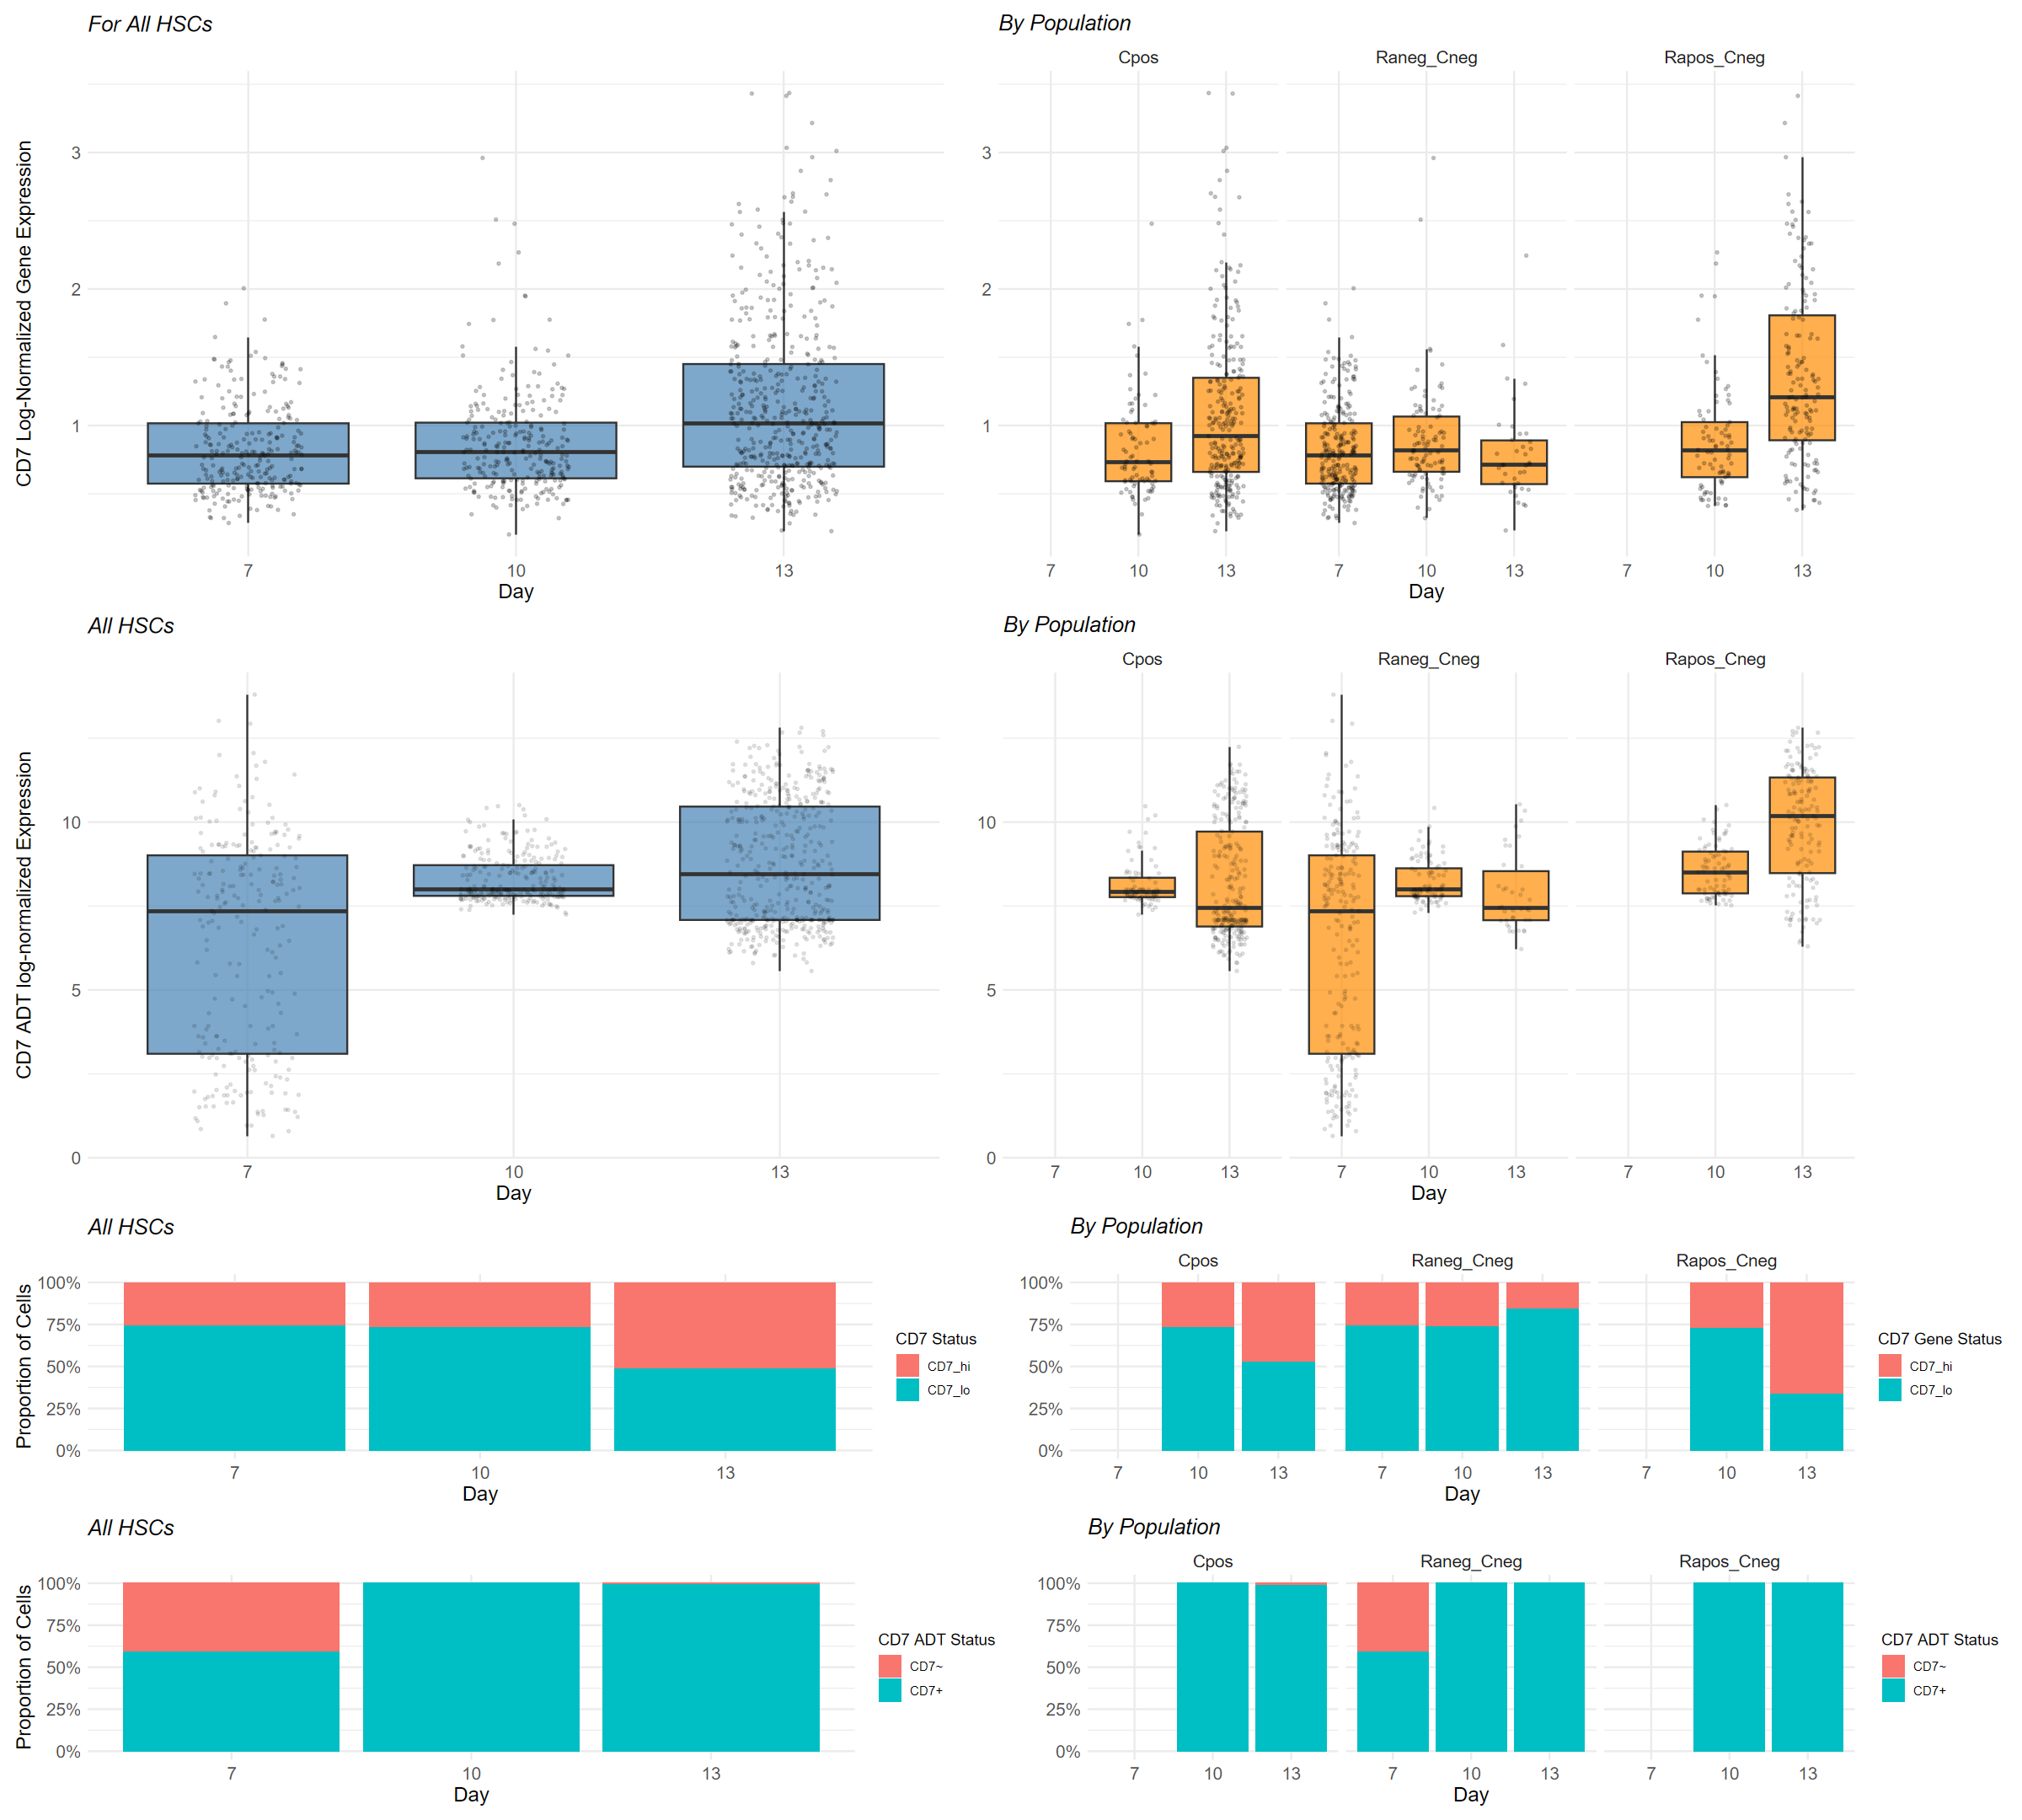

In [17]:
options(repr.plot.width = 20, repr.plot.height = 18)

((CombPlot_CD7_gene_expression / CombPlot_CD7_adt_expression) + (CombPlot_CD7_gene_prop / CombPlot_CD7_adt_prop)) + # nolint
    theme(plot.title = element_text(hjust = 0.5, size = 16, face = "bold"))


Here's my interpretations of what I am seeing: 

---
**First Row: CD7-Log Normalized Gene Expression Data, for All HSCs and By Population**

*CD7 Expression Across Time (All HSCs)*
- **Trend:** There is a **clear increase** in CD7 expression from Day 7 → Day 13.
- Median CD7 expression appears to **increase steadily**, and there’s a visible rise in the spread of values on Day 13.
- Day 13 shows a broader interquartile range (IQR) and more extreme outliers — suggesting **higher transcriptional heterogeneity** in CD7⁺ cells over time.
- **Interpretation:** This supports the idea that **CD7⁺ cells become more prominent or transcriptionally active as differentiation proceeds**, consistent with increasing T-lineage priming over time.

*CD7 Expression Across Time by Population*
- This is **really insightful** for dissecting cell-type-specific dynamics. Here’s what we can see:
**Cpos (C⁺)**
- Starts with moderate expression on Day 10, and by Day 13 CD7 expression is **dramatically higher**.
- Strongest rise among all populations.
- This might indicate that **C⁺ cells are strongly acquiring T-lineage bias** as time progresses.

*Rapos_Cneg (Ra⁺C⁻)*
- Similar to Cpos, with a noticeable bump in expression by Day 13.
- Suggests this population is **also transitioning**, though perhaps slightly delayed or with more heterogeneity.

*Raneg_Cneg (Ra⁻C⁻)*
- Expression is relatively flat across all timepoints.
- This supports the idea that Ra⁻C⁻ cells are **maintaining a primitive state** with **minimal T-lineage activation**.

*Summary Takeaways*
- **CD7 expression increases over time** across all cells, particularly in **Ra⁺C⁻ and C⁺ populations**.
- **Ra⁻C⁻ cells remain low and flat**, suggesting **they are least committed to T-lineage** — reinforcing their use as a baseline for comparison.
- I am seeing evidence that **CD7 tracks with populations known to acquire T-cell characteristics over time** at this stage.

--- 

**2nd Row: CD7-Log Normalized ADT Expression Data, for All HSCs and By Population**

The Results align completely with Row 1 on a qualitive level, so no additional interpretation is needed. 

---
**3rd Row: CD7-Log Normalized Changes in Proportion of Cells Over Time (GeneExpression Gating), for All HSCs and By Population**

*Proportion of CD7 Status Across Days (All HSCs)*
- **CD7⁺ cells increase from Day 7 to Day 13**, showing a rising trend in CD7 expression over time in the HSC population as a whole.
- This suggests that **CD7 expression may be associated with HSC maturation or progression over time**.

*Proportion of CD7 Status Across Days by HSC Population*
- **Cpos and Rapos_Cneg populations show a strong increase in CD7⁺ cells by Day 13**.
- **RaNeg_Cneg remains mostly CD7⁻ across all timepoints**, indicating it retains a more primitive phenotype.
- This supports the idea that **CD7 expression marks more mature or lineage-committed HSCs**, particularly T-lineage-biased ones.
---
**4th Row: CD7-Log Normalized Changes in Proportion of Cells Over Time (Surface Marker Gating), for All HSCs and By Population**

The Results align completely with Row 3 on a qualitive level, so no additional interpretation is needed. 

---


We can now begin conducting Statistical tests in `Phase 2` of our analysis. 

### Phase 2: Statistical Analysis 

Here, we will conduct statistical differences to discern differences between CD7 expression level and time, by ADT data and GeneExpression data. Let's begin by Looking at GeneExpression data: 

In [ ]:
cd7_day_slr <- lm(CD7_gene ~ Day, data = cd7_filtered_df)

tidy(cd7_day_slr)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.87094327,0.03069332,28.375663,5.779209e-130
Day7,-0.04823789,0.04361752,-1.105929,2.690270e-01
Day13,0.28143291,0.03830456,7.347243,4.238222e-13


Great! Here's the meaning of these results, as taught to me in STAT 301: 

* There is enough statistical evidence to make the claim that the mean log-CD7 expression in all HSCs (regardless of population) of the reference level (Day7) is 0.823, and is statistically significant at p < 0.05. 
* There is not enough statistical evidence to make the claim that the mean log-CD7 expression in all HSCs (regardless of population) of Day 10 cells is different from the Day 7 cells. 
* There is enough statistical evidence to make the claim that the mean log-CD7 expression in all HSCs (regardless of population) of Day 13 cells is 0.33 more than the Day 7 cells, at p < 0.05. 

Let's now repeat this experiment by focusing on the interaction between time and population, worked on below: 

In [26]:
# relevelling so Ra-C- is the reference level
cd7_filtered_df$Group <- factor(cd7_filtered_df$Group)
cd7_filtered_df$Group <- relevel(cd7_filtered_df$Group, ref = "Raneg_Cneg")

# relevelling so Day 10 is the reference level
cd7_filtered_df$Day <- relevel(cd7_filtered_df$Day, ref = "10")

cd7_daygroup_slr <- lm(CD7_gene ~ Day * Group, data = cd7_filtered_df)

tidy(cd7_daygroup_slr)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.889509825,0.04860987,18.29895522,1.367600e-64
Day7,-0.066804442,0.05721144,-1.16767626,2.432208e-01
Day13,-0.097935558,0.09229814,-1.06107837,2.889152e-01
GroupCpos,-0.056651580,0.07221989,-0.78443183,4.329759e-01
GroupRapos_Cneg,-0.002703804,0.07246332,-0.03731272,9.702432e-01
Day7:GroupCpos,NA,NA,NA,NA
Day13:GroupCpos,0.344717880,0.11058310,3.11727451,1.878406e-03
Day7:GroupRapos_Cneg,NA,NA,NA,NA
Day13:GroupRapos_Cneg,0.574620773,0.11348220,5.06353201,4.913448e-07


Here's the meaning of these results: 

* `(Intercept)`: There is enough statistical evidence to make the claim that the mean log-CD7 expression for Ra-C- cells at Day 10 is 0.89, and this is statistically significant (p < 0.05).
* `Day7`: There is not enough evidence to make the claim that the mean CD7 expression in Ra-C- cells at Day 7 differs from Day 10
* Day13`: There is not enough evidence to make the claim that the mean CD7 expression in Ra-C- cells at Day 13 differs from Day 10.
>*This means CD7 expression in Ra-C- population does not chhange with time.*
--
* `GroupCPos`: There is not enough evidence to make the claim that the mean CD7 expression in C+ cells at Day 7 differs from Ra-C- cells at Day 10.
* `GroupRapos_Cneg`: There is not enough evidence to make the claim that the mean CD7 expression in Ra+C- cells at Day 7 differs from Ra-C- cells at Day 10.
>*No statiatical difference in CD7 expression among populations on Day 7 compared to Day 10*
--
* `Day13:GroupCpos`: There is enough statistical evidence to  claim that the Day 13 C+ cells have a 0.345 higher log-CD7 expression than Ra-C- cells at Day 10, based on the individual effects of being C+ and Day 13 alone.
* `Day13:GroupRapos_Cneg`: There is strong statistical evidence to  claim that Day 13 Ra+C- cells have a 0.57 higher CD7 expression than Ra-C- cells at Day 10 based on the effects of being Ra+C- and Day 13 alone. 
>These interaction effects support the idea that CD7 expression increases specifically in more mature HSCs over time — especially in populations like Ra+C-, possibly marking T-lineage priming.


Let's now try this again, but with ADT expression data: 

In [ ]:
adt_day_slr <- lm(CD7_adt ~ Day, data = adt_filtered_df)

tidy(cd7_day_slr)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.87094327,0.03069332,28.375663,5.779209e-130
Day7,-0.04823789,0.04361752,-1.105929,2.690270e-01
Day13,0.28143291,0.03830456,7.347243,4.238222e-13


Here's the interpretation of these results: 

There is a **clear and significant increase** in CD7 ADT expression from **Day 7** to **Day 13**.

- `(Intercept)`: The mean log-CD7 ADT expression in all HSCs at Day 7 is **6.48**, and this is statistically significant (p ≪ 0.05).
- `Day 10`: There is enough **statistical evidence** to claim that **Day 10** cells have **1.83 units higher** CD7 ADT expression than Day 7 cells (**p ≪ 0.05**).
- `Day 13`: There is enough **statistical evidence** to claim that **Day 13** cells have **2.28 units higher** CD7 ADT expression than Day 7 cells (**p ≪ 0.05**).

> This suggests that **surface expression of CD7 protein is increasing steadily over time in HSCs**, in line with gene expression data — but with even greater magnitude.  
> The size of the increase (~2 units by Day 13) indicates **robust surface-level protein accumulation**, consistent with possible CD7⁺ sorting enrichment or broader protein-level activation.

Now let's repeat this model, but with the interaction terms! 

In [28]:
# relevelling so Ra-C- is the reference level
adt_filtered_df$Group <- factor(adt_filtered_df$Group)
adt_filtered_df$Group <- relevel(adt_filtered_df$Group, ref = "Raneg_Cneg")

# relevelling so Day 10 is the reference level
adt_filtered_df$Day <- relevel(adt_filtered_df$Day, ref = "10")

adt_daygroup_slr <- lm(CD7_gene ~ Day * Group, data = adt_filtered_df)

tidy(adt_daygroup_slr)


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.889509825,0.04913255,18.10428668,3.431332e-63
Day7,-0.055293359,0.05884042,-0.93971723,3.476007e-01
Day13,-0.097935558,0.09329059,-1.04979037,2.940806e-01
GroupCpos,-0.056651580,0.07299644,-0.77608686,4.378903e-01
GroupRapos_Cneg,-0.002703804,0.07324249,-0.03691578,9.705599e-01
Day7:GroupCpos,NA,NA,NA,NA
Day13:GroupCpos,0.344717880,0.11177216,3.08411222,2.100430e-03
Day7:GroupRapos_Cneg,NA,NA,NA,NA
Day13:GroupRapos_Cneg,0.574620773,0.11470244,5.00966498,6.496432e-07



- `(Intercept)`: There is enough statistical evidence to make the claim that the mean log-CD7 ADT expression for Ra−C− cells at Day 10 is 0.89, and this is statistically significant (p < 0.05).  
- `Day7`: There is not enough statistical evidence to make the claim that the mean CD7 ADT expression in Ra−C− cells at Day 7 differs from Day 10.  
- `Day13`: There is not enough statistical evidence to make the claim that the mean CD7 ADT expression in Ra−C− cells at Day 13 differs from Day 10.

> *This means CD7 ADT expression in Ra−C− population does not change with time.* --

- `GroupCpos`: There is not enough statistical evidence to make the claim that the mean CD7 ADT expression in C+ cells at Day 10 differs from Ra−C− cells at Day 10.  
- `GroupRapos_Cneg`: There is not enough evidence to make the claim that the mean CD7 ADT expression in Ra+C− cells at Day 10 differs from Ra−C− cells at Day 10.

> *No statistical difference in CD7 ADT expression among populations on Day 10 compared to Ra−C−* --

- `Day13:GroupCpos`: There is enough statistical evidence to claim that the Day 13 C+ cells have a 0.345 higher log-CD7 ADT expression than Ra−C− cells at Day 10, based on the combined effects of being C+ and Day 13.  
- `Day13:GroupRapos_Cneg`: There is strong statistical evidence to claim that Day 13 Ra+C− cells have a 0.57 higher CD7 ADT expression than Ra−C− cells at Day 10, based on the effects of being Ra+C− and Day 13.

> *These interaction effects support the idea that CD7 ADT expression increases specifically in more mature HSCs over time — especially in populations like Ra+C−, possibly marking T-lineage priming.*  


---

### RQ2: Is There a Statistical Difference in CD7 Expression Between Ra-C- cells (Primitive), and Ra-C+/C+ Populations (More Mature)? 

In haematopoiesis, surface markers like CD7 help us trace lineage commitment - especially towards T-cell fates. From the transcriptomic trajectory and prior results (RQ1), it appears that CD7 expression increases over real time (Day 7->13), suggesting it's tied to cellular maturation or lineage priming.

We now want to ask: **Does this trend correlate with more mature immunophenotypes?**
* Ra-C⁻ cells are considered the most primitive.
* Ra-C⁺ and especially C⁺ are considered more differentiated.

So, if CD7 is truly a marker of T-lineage bias or maturity, we’d expect its expression to be significantly (in a statistical sense) lower in Ra-C⁻, and higher in C⁺/Ra-C⁺.

---

Some of the Analysis we will do: 
- Boxplot Visualizations of the 3 populations CD7 expression, regardless of time. 
- ANOVA test comparing the CD7 expression among the 3 populations

Lets begin with the CD7 visualization using boxplots: 

In [ ]:
# Step 1: Filter to 3 populations and CD7+ / CD7_low cells only
rq2_df <- cd7_filtered_df %>%
  filter(
    Group %in% c("Raneg_Cneg", "Rapos_Cneg", "Cpos"),
    CD7_status != "CD7_neg"
  )

# Step 2: Ensure Group is a factor with a sensible order
rq2_df$Group <- factor(rq2_df$Group, levels = c("Raneg_Cneg", "Rapos_Cneg", "Cpos"))

# Step 3: Create boxplot
ggplot(rq2_df, aes(x = Group, y = CD7_expr, fill = Group)) +
  geom_boxplot(outlier.shape = NA, alpha = 0.7) +
  geom_jitter(width = 0.2, size = 0.8, alpha = 0.4) +
  labs(
    title = "CD7 Expression Across HSC Populations",
    x = "HSC Population",
    y = "CD7 log-normalized Expression"
  ) +
  theme_minimal() +
  theme(legend.position = "none")


- Rapos_Cneg (Ra-C⁺) shows the highest median CD7 expression, and a wide distribution — suggesting a subset of strongly CD7⁺ cells.

- Cpos (C⁺) also has moderate CD7 expression, with slightly lower median than Rapos_Cneg but still elevated.

- Raneg_Cneg (Ra-C⁻) has the lowest CD7 expression overall, with a tighter range and fewer high outliers.

**Takeaway**: CD7 expression increases in more differentiated populations, suggesting that CD7⁺ cells are enriched in more mature, lineage-primed HSC subsets.

Let's now quantify this with ANOVA

In [ ]:
# Fit linear model
cd7_group_lm <- lm(CD7_expr ~ Group, data = cd7_filtered_df)

# ANOVA test
anova(cd7_group_lm)

tidy(cd7_group_lm)


**Interpretation of ANOVA Results** 

`F = 41.07, p < 0.0001`

>There is enough statistical evidence to conclude that at least one HSC population has a different mean log-CD7 expression compared to the others.

---

**Interpretation of Linear Model Results**

* There is enough statistical evidence to make the claim that Mean log-CD7 expression in Ra-C⁻ cells is 0.837 (log-normalized). 
* There is enough statistical evidence to make the claim that Ra+C⁻ cells have a log-CD7 expression 0.367 higher than Ra-C⁻ cells.
* There is enough statistical evidence to make the claim that C+ cells have a log-CD7 expression 0.186 higher than the Ra-C- cells. 

> There is enough evidence to conclude that CD7 levels differ across each HSC population, and the difference are statistically significant at at 95% confidence. RA+C- cells have the highest CD7 expression levels, followed by C+ and Ra-C- cells. 

This sets us up perfectly for RQ3, pursued below! 

### RQ3: Does the Increase in CD7 Expression statisticallly correlate with an Increase in Known T-Cell Genes?

Fangwu identified the Ra⁺C⁻ population as a transient, lymphoid-primed intermediate enriched for T/NK lineage gene programs. Given that CD7 is a canonical early T-cell marker, it would be expected that CD7 expression is elevated in Ra⁺C⁻ cells (which it is, as per analysis done in RQ2). However, by quantifying CD7 expression and testing its correlation with broader T-lineage transcriptional signatures, I aim to determine whether CD7 truly reflects T-lineage bias — or whether it is insufficient as a standalone enrichment marker.

The key here is to statistically validate CD7 as a Proxy for T-cell bias. 

To do this, we will be completing 4 Statistical tests, which will rely on the common workflow outlined here:

1. Define a T-Cell Signature. I will do so by using the T-cell gene list that Laura provided, which also include genes from John Edgar's thesis. 
2. Score each cell's T-cell program, using SingleCellExperiment objects native module scoring functionality 
3. Conduct Different Tests: 

    a. Compare CD7 expression with T-cell program score 

    b. Statistical Difference in T-cell correlation scores between CD7-, CD7 lo, CD7+ groups 

    c. Differential Gene Expression Analysis of T-cell genes between CD7lo and CD7+ groups

Let's begin implementing this plan below: 

In [ ]:
# Defining T-Cell Program Genes
# --- 1. Define the T-cell program gene list ---
tcell_genes <- c(
  "RAG2", "NOTCH1", "CD3D", "CD3E", "CD3G",
  "TCF7", "GATA3", "BCL11B", "RAG1", "DTX1",
  "IL7R", "PTCRA", "LEF1", "SPI1", "RUNX1",
  "BCL11A", "IKZF1", "ZBTB16"
)

# --- 2. Ensure genes are present in the SCE object ---
tcell_genes_present <- intersect(tcell_genes, rownames(merge2))

# Optional: print genes that were missing
missing_genes <- setdiff(tcell_genes, rownames(merge2))
cat("Missing genes:", paste(missing_genes, collapse = ", "), "\n")

# --- 3. Score each cell using average log-normalized expression ---
# (assuming logcounts(merge2) contains log-normalized RNA expression)
tcell_scores <- colMeans(logcounts(merge2_light)[tcell_genes_present, , drop = FALSE]) # nolint

# --- 4. Store the T-cell score in the metadata ---
colData(merge2_light)$Tcell_score <- tcell_scores


Here is the justification for the genes I addded to Laura's original list: 

- **IL7R** — Essential cytokine receptor for T-cell development; early expression bias.
- **PTCRA** — Pre-TCR alpha chain, seen in early thymocyte development.
- **LEF1** — Wnt pathway TF that overlaps with TCF7 and is T-lineage linked.
- **SPI1 (PU.1)** — Important for early lymphoid/myeloid balance, and relevant to early lymphoid specification.
- **RUNX1** — Highly conserved regulator of lymphoid commitment (T/B), also activated early.
- **BCL11A** — Paralog of BCL11B, also involved in early lymphoid fate decision.
- **IKZF1 (Ikaros)** — Key lymphoid TF, expressed early in T- and B-lineage priming.
- **ZBTB16 (PLZF)** — Implicated in innate-like T cell precursors; upregulated in some lymphoid-biased HSCs.


In [ ]:
# Sanity check statement to see if a gene is present in the SCE object

"CD3D" %in% rownames(merge2)


We can now begin conducting our tests to validate the counter hypothesis: CD7 alone does not track well wth the broader T-lineage transcriptional program. As mentioned, above, we will be implementing this using 3 tests: 

#### Test Alpha: Correlation Between CD7 Expression and T-Cell Module Score 

This will quantify whether CD7 expression alone tracks well with the broader T-lineage transcriptional program. The steps I will implement will be: 

1. Filter to non-zero CD7-expressing cells (to avoid skew).

2. Plot a scatterplot of CD7_expr vs Tcell_score.

3. Fit a simple linear regression: Tcell_score ~ CD7_expr

4. Compute and interpret the correlation (Pearson or Spearman).

Let's implement this and analyze it below! 

In [ ]:
# Filter to CD7-positive cells only
cd7_pos_df <- as.data.frame(colData(merge2_light)) %>%
  filter(CD7_expr > 0)

# Scatterplot of CD7_expr vs. Tcell_score
ggplot(cd7_pos_df, aes(x = CD7_expr, y = Tcell_score)) +
  geom_point(alpha = 0.4, color = "steelblue") +
  geom_smooth(method = "lm", se = TRUE, color = "darkred") +
  labs(
    title = "Correlation Between CD7 Expression and T-cell Program Score",
    x = "CD7 log-normalized Expression",
    y = "T-cell Module Score"
  ) +
  theme_minimal()

# Linear model: Tcell_score ~ CD7_expr
cd7_model <- lm(Tcell_score ~ CD7_expr, data = cd7_pos_df)
tidy(cd7_model) # Tidy summary of model (optional)

# Pearson correlation
pearson_result <- cor.test(cd7_pos_df$CD7_expr, cd7_pos_df$Tcell_score, method = "pearson")
print(pearson_result)

# Spearman correlation (if you want a rank-based test)
spearman_result <- cor.test(cd7_pos_df$CD7_expr, cd7_pos_df$Tcell_score, method = "spearman")
print(spearman_result)


ILCS/NK cells vs CD8 cells - whats the true distrinction boundary.  These are all t-cells. 


Look up ILCS and Lymphoid branch sub-phenotypes. 